In [1]:
#in case of running this in colab 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#not included by default
!pip install rasterio 
!pip install geopandas
!pip install pycrs

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
  Found existing installation: click 8.0.0
    Uninstalling click-8.0.0:
      Successfully uninstalled click-8.0.0
     |████████████████████████████████| 1.0MB 26.1MB/s 
     |████████████████████████████████| 15.3MB 235kB/s 
     |████████████████████████████████| 6.5MB 46.2MB/s 
  Created wheel for pycrs: filename=PyCRS-1.0.2-cp37-none-any.whl size=32683 sha256=ab85ffa8cc8b85bfcd4e978224858266867a571d371369eeade1cb4d3cffbb1e
  Stored in directory: /root/.cache/pip/wheels/1a/c9/56/648f762bd41fdb03454be51b8a7069795925168833cb61f316
Successfully built pycrs


In [3]:
#imports 

import rasterio 
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import pandas as pd
import numpy as np
from matplotlib import image as im
from matplotlib import pyplot as plt
from affine import Affine
from keras import layers
from keras import Input
import keras
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.metrics import MeanIoU

In [4]:
#MapBiomas label 
label_path = "/content/drive/MyDrive/Honors/MapBiomas/COLECAO_5_DOWNLOADS_COLECOES_ANUAL_AMAZONIA_AMAZONIA-2019.tif"

#a portion of the original satellite image
image_path = "/content/drive/MyDrive/Honors/MapBiomas/MAPBIOMAS-EXPORT/input.tif"

In [5]:
#check the basic info - note how much the label is bigger than the satellite image
with rasterio.open(image_path) as image:
    print(image.profile)

with rasterio.open(label_path) as label:
    print(label.profile)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 3242, 'height': 3328, 'count': 102, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3243, 'height': 3328, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["unknown",DATUM["unknown",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["unknown",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107876,
       0.0, -0.00026949458523585647, -6.617709035051692), 'tiled': False, 'interleave': 'band'}


In [6]:
#to clip the label to the same size and area as the image, we need to get to its transformation
image.transform

Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692)

In [7]:
#to get the coordinates of the upper left and lower right of the image
print(image.transform * (0,0))
print(image.transform * (image.width, image.height))

(-55.80990315107875, -6.617709035051692)
(-54.936201705744104, -7.514587014716622)


For interpretation of these keys visit: https://rasterio.readthedocs.io/en/latest/quickstart.html

# Clipping the label map to fit the sizes of the small satellite image

In [8]:
#these are now the coordinates to which we fit the label
minx, miny = -55.80990315107875, -6.617709035051692
maxx, maxy = -54.936201705744104, -7.514587014716622
bbox = box(minx, miny, maxx, maxy)

In [9]:
#insert it into a GeoDataFrame
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
geo = geo.to_crs(crs=label.crs.data)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [11]:
#get the coordinates
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[-54.936201705744104, -6.617709035051692], [-54.936201705744104, -7.514587014716622], [-55.80990315107875, -7.514587014716622], [-55.80990315107875, -6.617709035051692], [-54.936201705744104, -6.617709035051692]]]}]


In [12]:
#clip the raster with the polygon of proper coordinates
label = rasterio.open(label_path)
out_label, out_transform = mask(label, shapes=coords, crop=True)

In [13]:
#copy the metadata that needs to be modified after the clipping
out_meta = label.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3243, 'height': 3328, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["unknown",DATUM["unknown",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["unknown",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107876,
       0.0, -0.00026949458523585647, -6.617709035051692)}


In [14]:
#finally update the metadata
out_meta.update({"driver": "GTiff",
                  "height": out_label.shape[1],
                  "width": out_label.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(4326).to_proj4()} #the epsg code is the same as from the original meta
                          )

In [15]:
#save the clipped file 
with rasterio.open(label_path, "w", **out_meta) as dest:
  dest.write(out_label)

In [16]:
with rasterio.open(label_path) as label:
    print(label.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 3243, 'height': 3328, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["unknown",DATUM["unknown",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["unknown",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107876,
       0.0, -0.00026949458523585647, -6.617709035051692), 'tiled': False, 'interleave': 'band'}


In [17]:
#check if the coordinates are the same as with the image
print(label.transform * (0, 0))
print(label.transform * (label.width, label.height))

(-55.80990315107876, -6.617709035051692)
(-54.93593221115887, -7.514587014716622)


Text(0, 0.5, 'Row #')

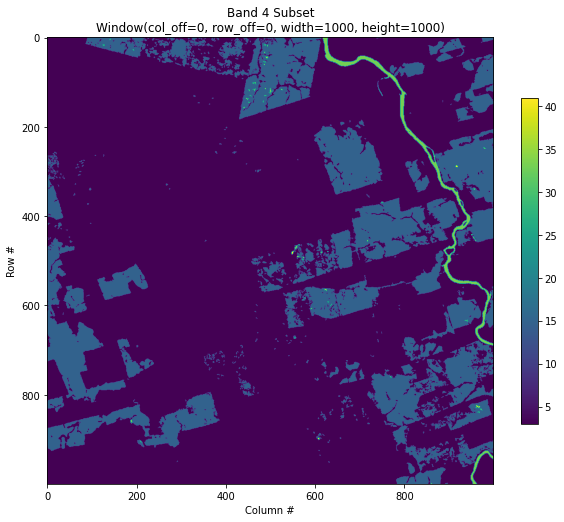

In [18]:
#visualize part of the map

window = rasterio.windows.Window(0, 0, 1000, 1000)

with rasterio.open(label_path) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(10,12))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

# Data generator

In [19]:
def data_gen(src, lab, for_train: bool):
    '''
    generate labels to feed to the U-net
    filter the image using its several bands
    change the value for_train to False to use it for test data
    batch size could be added aswell, this version is used for debug for now
    '''
    
    #list of the selected bands
    bands = [1,2,3,4,5] # for example

    split_thresh = 0.8
    width = 12 # 158 = width/256
    height = 13 # 221 = height/256

    train_width = int(width*split_thresh)
    
    if for_train:
        for train_i in range(train_width):
            for train_j in range(height):
                train_window = rasterio.windows.Window(int(train_i*256), int(train_j*256), 256, 256)
                img_crop = np.zeros((256, 256, len(bands)))
                # filter the bands
                for i, band in enumerate(bands):
                    img_crop[:,:,i] = src.read(band, window=train_window)
                label_crop = lab.read(1, window=train_window).reshape((256, 256, 1))
                
                yield (img_crop, label_crop)
                
    else:
        for test_i in range(train_width, width): # the rest 20% part of the image
            for test_j in range(height):
                test_window = rasterio.windows.Window(int(test_i*256), int(test_j*256), 256, 256)
                img_crop = np.zeros((256, 256, len(bands)))
                for i, band in enumerate(bands):
                    img_crop[:,:,i] = src.read(band, window=test_window)
                label_crop = lab.read(1, window=train_window).reshape((256, 256, 1))
                
                yield (img_crop, label_crop)

In [20]:
def make_batches(size, src, lab, for_train):
  """
  converts the python generator into a tf.data.Dataset object
  and builds batches for of data
  """
  gen = lambda: (row for row in data_gen(src, lab, for_train)) #to make the generator a callable for the line bellow
  dataset = Dataset.from_generator(gen, output_types=(tf.float32, tf.float32))
  dataset = dataset.shuffle(156) #shuffle as many as there are samples
  dataset = dataset.repeat(2)    #repeat some samples at most twice
  dataset = dataset.batch(size)  
  return(dataset)


In [21]:
def build_model(input_layer, start_neurons):
    """
    makes a U-net with 4 down- and up-sampling layers with the functional API
    """
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(0.5)(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])
    uconv3 = layers.Dropout(0.5)(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Dropout(0.5)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Dropout(0.5)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input(shape=(256,256,1))
output_layer = build_model(input_layer, 64)

In [31]:
model = keras.Model(inputs=input_layer, outputs=output_layer)

#the best and most used metric for image segmentation we use Intersection over Union
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss='categorical_crossentropy', 
    metrics=MeanIoU(num_classes=42))

In [32]:
label = rasterio.open(label_path)
image = rasterio.open(image_path)

In [33]:
model.fit(make_batches(10, image, label, for_train = True), validation_data = make_batches(10, image, label, for_train=False), epochs=2)

Epoch 1/2


TypeError: ignored